# Import some Libraries

In [1]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso   
from sklearn.svm import SVR

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score

# for mape
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# for smape
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# per hour mae
def per_hour_mae(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.abs(y_true - y_pred)

import warnings
warnings.filterwarnings("ignore")

# Prepare different type of calibration model using ML and DL based algorithms with base+derived features

In [2]:
def base_model(name_list):
    '''
    Input:- give input and output pairs at different site with base+derived features
    Output:- calibrated results at different sites
    '''
    # base+derived features path
    base_derived_data_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\data\base_derived_features'
    
    for name in name_list:
        
        print('Site Name:', name)
        # read data files
        df_name = pd.read_csv(base_derived_data_path + '/base_derived_innu_outu_startupA_'+name+'.csv')
        
        # convert date into standard format
        df_name.Date = pd.to_datetime(df_name.Date,dayfirst=True)
        
        # prepare training, validation and testing data pairs
        a = df_name.shape[0] - 336*2
        b = 336
        
        # prepare set for train, val and test date
        train_date = df_name.iloc[:a,0:1].values
        val_date = df_name.iloc[a:a+b,0:1].values
        test_date = df_name.iloc[a+b:,0:1].values
        
        # prepare set for train, val and test uncalibrated PM2.5
        train_lowcost = df_name.iloc[:a,2:3].values
        val_lowcost = df_name.iloc[a:a+b,2:3].values
        test_lowcost = df_name.iloc[a+b:,2:3].values
        
        # normalize the input features
        innu = df_name.drop(['Date','PM25','hour','hour_sin','hour_cos'],axis=1)
        outu = df_name[['Date','PM25','hour_sin','hour_cos']]
        innu_scaled = StandardScaler().fit_transform(innu.values)
        innu_scaled_df = pd.DataFrame(innu_scaled, index=innu.index, columns=innu.columns)
        df1 = pd.concat([outu,innu_scaled_df],axis=1)
        innu1 = df1.drop(['Date','PM25'],axis=1)
        outu1 = df1[['PM25']]
        innu_f1 = innu1.iloc[:,:].values
        outu_f1 = outu1.iloc[:,:].values
        
        # prepare training, validation and testing data pairs in 2D
        X_train = innu_f1[:a,:].astype(np.float32)
        y_train = outu_f1[:a,:].astype(np.float32)
        X_val = innu_f1[a:a+b,:].astype(np.float32)
        y_val = outu_f1[a:a+b,:].astype(np.float32)
        X_test = innu_f1[a+b:,:].astype(np.float32)
        y_test = outu_f1[a+b:,:].astype(np.float32)
        
        # prepare training, validation and testing data pairs in 1D
        X_train_1d = X_train.reshape(X_train.shape[0],X_train.shape[1])
        y_train_1d = y_train.reshape(y_train.shape[0],)
        X_val_1d = X_val.reshape(X_val.shape[0],X_val.shape[1])
        y_val_1d = y_val.reshape(y_val.shape[0],)
        X_test_1d = X_test.reshape(X_test.shape[0],X_test.shape[1])
        y_test_1d = y_test.reshape(y_test.shape[0],)
        
        # Uncalibrated performance
        unc_accuracy = pd.DataFrame({
        'Parameters': ['R2_train','MAPE(%)_train','SMAPE(%)_train','R2_val','MAPE(%)_val','SMAPE(%)_val','R2_test','MAPE(%)_test','SMAPE(%)_test'],
        'unc': [ r2_score(y_train,train_lowcost),mape(y_train,train_lowcost),smape(y_train,train_lowcost), 
                 r2_score(y_val,val_lowcost),mape(y_val,val_lowcost), smape(y_val,val_lowcost),
                 r2_score(y_test,test_lowcost),mape(y_test,test_lowcost),smape(y_test,test_lowcost)]})
        unc_accuracy=unc_accuracy.transpose()
        unc_accuracy
        
        # Calibration using LinearRegression (lr)
        lr = LinearRegression()
        lr.fit(X_train_1d,y_train_1d)
        lr_pred_train = lr.predict(X_train_1d)
        lr_pred_val = lr.predict(X_val_1d)
        lr_pred_test = lr.predict(X_test_1d)
        
        # Calibrated results using lr
        lr_accuracy = pd.DataFrame({
        'lr': [ r2_score(y_train_1d,lr_pred_train),mape(y_train_1d,lr_pred_train),smape(y_train_1d,lr_pred_train), 
                 r2_score(y_val_1d,lr_pred_val),mape(y_val_1d,lr_pred_val), smape(y_val_1d,lr_pred_val),
                 r2_score(y_test_1d,lr_pred_test),mape(y_test_1d,lr_pred_test),smape(y_test_1d,lr_pred_test)]})
        lr_accuracy=lr_accuracy.transpose()
        
        # model's pat for save 
        base_derived_features_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\base+derived_features_model'
        
        
        # save the trained model
        pickle.dump(lr, open(base_derived_features_model_path + '\lr_model_' + name + '.sav','wb'))
        
        # Calibration using Support Vector Regression (svr)
        svr = SVR(kernel='linear',epsilon=0.0001,tol=0.01,C=1.1)
        svr.fit(X_train_1d,y_train_1d)
        svr_pred_train = svr.predict(X_train_1d)
        svr_pred_val = svr.predict(X_val_1d)
        svr_pred_test = svr.predict(X_test_1d)
        
        # Calibrated results using svr
        svr_accuracy = pd.DataFrame({
        'svr': [ r2_score(y_train_1d,svr_pred_train),mape(y_train_1d,svr_pred_train),smape(y_train_1d,svr_pred_train), 
                 r2_score(y_val_1d,svr_pred_val),mape(y_val_1d,svr_pred_val), smape(y_val_1d,svr_pred_val),
                 r2_score(y_test_1d,svr_pred_test),mape(y_test_1d,svr_pred_test),smape(y_test_1d,svr_pred_test)]})
        svr_accuracy=svr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(svr, open(base_derived_features_model_path + '\svr_model_' + name + '.sav','wb'))
        
        # Calibration using Elastic Net Regression (enr)
        enr = ElasticNet()
        enr.fit(X_train_1d,y_train_1d)
        enr_pred_train = enr.predict(X_train_1d)
        enr_pred_val = enr.predict(X_val_1d)
        enr_pred_test = enr.predict(X_test_1d)
        
        # Calibrated results using enr
        enr_accuracy = pd.DataFrame({
        'enr': [ r2_score(y_train_1d,enr_pred_train),mape(y_train_1d,enr_pred_train),smape(y_train_1d,enr_pred_train), 
                 r2_score(y_val_1d,enr_pred_val),mape(y_val_1d,enr_pred_val), smape(y_val_1d,enr_pred_val),
                 r2_score(y_test_1d,enr_pred_test),mape(y_test_1d,enr_pred_test),smape(y_test_1d,enr_pred_test)]})
        enr_accuracy=enr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(enr, open(base_derived_features_model_path + '\enr_model_' + name + '.sav','wb'))
        
        # Calibration using Ridge Regression (rr)
        rr = Ridge(alpha = 1,tol = 0.0001)
        rr.fit(X_train_1d,y_train_1d)
        rr_pred_train = rr.predict(X_train_1d)
        rr_pred_val = rr.predict(X_val_1d)
        rr_pred_test = rr.predict(X_test_1d)
        
        # Calibrated results using rr
        rr_accuracy = pd.DataFrame({
        'rr': [ r2_score(y_train_1d,rr_pred_train),mape(y_train_1d,rr_pred_train),smape(y_train_1d,rr_pred_train), 
                 r2_score(y_val_1d,rr_pred_val),mape(y_val_1d,rr_pred_val), smape(y_val_1d,rr_pred_val),
                 r2_score(y_test_1d,rr_pred_test),mape(y_test_1d,rr_pred_test),smape(y_test_1d,rr_pred_test)]})
        rr_accuracy=rr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(rr, open(base_derived_features_model_path + '/rr_model_' + name + '.sav','wb'))
        
        # Calibration using Lasso Regression (lar)
        lar = Lasso()
        lar.fit(X_train_1d,y_train_1d)
        lar_pred_train = lar.predict(X_train_1d)
        lar_pred_val = lar.predict(X_val_1d)
        lar_pred_test = lar.predict(X_test_1d)
        
        # Calibrated results using lar 
        lar_accuracy = pd.DataFrame({
        'lar': [ r2_score(y_train_1d,lar_pred_train),mape(y_train_1d,lar_pred_train),smape(y_train_1d,lar_pred_train), 
                 r2_score(y_val_1d,lar_pred_val),mape(y_val_1d,lar_pred_val), smape(y_val_1d,lar_pred_val),
                 r2_score(y_test_1d,lar_pred_test),mape(y_test_1d,lar_pred_test),smape(y_test_1d,lar_pred_test)]})
        lar_accuracy=lar_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lar, open(base_derived_features_model_path + '\lar_model_' + name + '.sav','wb'))
        
        # Calibration using Dense Neural Network (dnn)
        early_stopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 100,
                               restore_best_weights = True)
        dnn = Sequential()
        dnn.add(Dense(512, input_shape = (X_train.shape[1],), kernel_initializer='normal',
                    activation='relu'))
        dnn.add(Dense(256, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(128, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(64, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(32, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(16, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(8, kernel_initializer='normal', activation='relu'))
        dnn.add(Dense(1))
        dnn.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3), metrics=['mse'])
        history = dnn.fit(X_train, y_train, epochs=2000,
                  validation_data = (X_val,y_val),
                  callbacks=[early_stopping])
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test = dnn.predict(X_test)
        
        # Calibrated results using dnn 
        dnn_accuracy = pd.DataFrame({
        'dnn': [ r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
                 r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
                 r2_score(y_test,dnn_pred_test),mape(y_test,dnn_pred_test),smape(y_test,dnn_pred_test)]})
        dnn_accuracy=dnn_accuracy.transpose()
        
        # save the trained model
        dnn.save(base_derived_features_model_path + '\dnn_model_' + name + '.h5')
        
        # save the entire model results
        result_name = pd.concat([unc_accuracy,lr_accuracy,svr_accuracy,enr_accuracy,rr_accuracy,lar_accuracy,dnn_accuracy])
        
        # path of base features calibrated results
        base_derived_features_results_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\results\base+derived_features_results'
        result_name.to_csv(base_derived_features_results_path+  '/base_derived_features_acc_tables_startupA_'+ name + '.csv', index=False)
        
        # calibrated and uncalibrated PM2.5 visualization for testing period
        fig, ax = plt.subplots(1,1,figsize = (15,5), sharex = False,sharey=True)
        plt.plot(test_date,test_lowcost, lw =1.5, color = 'brown',label='Uncalibrated')
        plt.plot(test_date,y_test, lw =1.5, color = 'k',label='Reference')
        plt.plot(test_date,lr_pred_test, lw =1.5, color = 'r',label='LR (Calibrated)')
        plt.plot(test_date,dnn_pred_test, lw =1.5, color = 'b',label='DNN (Calibrated)')
        locator=MaxNLocator(prune='both',nbins=3)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Date',fontsize = 30)
        plt.ylabel('PM$_{2.5}$ ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([test_date[0],test_date[-1]])
        plt.ylim([0,300])
        plt.title(name,fontsize = 30,x=0.8,y=0.8)
        plt.savefig(base_derived_features_results_path+  '/base_derived_features_cal_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')
        
        # Accumulated Graphs based on hourly MAE
        lr_hourly_mae = per_hour_mae(y_test_1d,lr_pred_test).reshape(y_test_1d.shape[0],1)
        svr_hourly_mae = per_hour_mae(y_test_1d,svr_pred_test).reshape(y_test_1d.shape[0],1)
        enr_hourly_mae = per_hour_mae(y_test_1d,enr_pred_test).reshape(y_test_1d.shape[0],1)
        rr_hourly_mae = per_hour_mae(y_test_1d,rr_pred_test).reshape(y_test_1d.shape[0],1)  
        lar_hourly_mae = per_hour_mae(y_test_1d,lar_pred_test).reshape(y_test_1d.shape[0],1)
        dnn_hourly_mae = per_hour_mae(y_test,dnn_pred_test).reshape(y_test.shape[0],1)
        
        def accumulative_mae(hourly_mae):
            """
            Convert hourly mae into accumulative format i.e.,
            mae at hour 2 is the sum of mae at hour 1 and hour 2
            """
            no_of_hour = 336
            mae = np.zeros([no_of_hour,1])
            for i in range(no_of_hour):
                mae[i] = mae[i-1] + hourly_mae[i]
            return mae
        lr_accumulative_mae = accumulative_mae(lr_hourly_mae)
        svr_accumulative_mae = accumulative_mae(svr_hourly_mae)
        enr_accumulative_mae = accumulative_mae(enr_hourly_mae)
        rr_accumulative_mae = accumulative_mae(rr_hourly_mae)
        lar_accumulative_mae = accumulative_mae(lar_hourly_mae)
        dnn_accumulative_mae = accumulative_mae(dnn_hourly_mae)
        
        # Accumulated MAE Visualization
        fig, ax = plt.subplots(1,1,figsize = (15,4), sharex = False,sharey=True)
        hour = np.arange(1,337,1)
        plt.plot(hour,lr_accumulative_mae, lw =1.5, color = 'r',label='LR')
        plt.plot(hour,svr_accumulative_mae, lw =1.5, color = 'olive',label='SVR')
        plt.plot(hour,enr_accumulative_mae, lw =1.5, color = 'y',label='ENR')
        plt.plot(hour,rr_accumulative_mae, lw =1.5, color = 'c',label='RR')
        plt.plot(hour,lar_accumulative_mae, lw =1.5, color = 'm',label='LAR')
        plt.plot(hour,dnn_accumulative_mae, lw =1.5, color = 'b',label='DNN')
        locator=MaxNLocator(prune='both',nbins=4)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Hours',fontsize = 30)
        plt.ylabel('MAE ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([hour[0],hour[-1]])
        plt.ylim([0,7000])
        plt.title(name,fontsize = 30,x=0.5,y=0.8)
        plt.savefig(base_derived_features_results_path+  '/base_derived_features_mae_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')

# Get the calibrated results for different site of startup's A

Site Name: Airport
Epoch 1/2000
43/43 [==============================] - 6s 75ms/step - loss: 2914.6588 - mse: 2914.6588 - val_loss: 994.4510 - val_mse: 994.4510
Epoch 2/2000
43/43 [==============================] - 0s 9ms/step - loss: 941.5528 - mse: 941.5528 - val_loss: 791.2130 - val_mse: 791.2130
Epoch 3/2000
43/43 [==============================] - 0s 9ms/step - loss: 352.4665 - mse: 352.4665 - val_loss: 342.3126 - val_mse: 342.3126
Epoch 4/2000
43/43 [==============================] - 0s 8ms/step - loss: 173.4386 - mse: 173.4386 - val_loss: 108.2465 - val_mse: 108.2465
Epoch 5/2000
43/43 [==============================] - 0s 8ms/step - loss: 125.3535 - mse: 125.3535 - val_loss: 111.1151 - val_mse: 111.1151
Epoch 6/2000
43/43 [==============================] - 0s 8ms/step - loss: 94.8873 - mse: 94.8873 - val_loss: 83.4188 - val_mse: 83.4188
Epoch 7/2000
43/43 [==============================] - 0s 9ms/step - loss: 85.9765 - mse: 85.9765 - val_loss: 69.5371 - val_mse: 69.5371
Epoch 

43/43 [==============================] - 0s 9ms/step - loss: 28.0662 - mse: 28.0662 - val_loss: 58.8469 - val_mse: 58.8469
Epoch 120/2000
43/43 [==============================] - 0s 9ms/step - loss: 28.0993 - mse: 28.0993 - val_loss: 78.9902 - val_mse: 78.9902
Epoch 121/2000
43/43 [==============================] - 0s 8ms/step - loss: 36.1848 - mse: 36.1848 - val_loss: 76.5844 - val_mse: 76.5844
Epoch 122/2000
43/43 [==============================] - 0s 8ms/step - loss: 29.4020 - mse: 29.4020 - val_loss: 85.5386 - val_mse: 85.5386
Epoch 123/2000
43/43 [==============================] - 0s 9ms/step - loss: 30.1777 - mse: 30.1777 - val_loss: 60.0844 - val_mse: 60.0844
Epoch 124/2000
43/43 [==============================] - 0s 7ms/step - loss: 29.8654 - mse: 29.8654 - val_loss: 66.1305 - val_mse: 66.1305
Epoch 125/2000
43/43 [==============================] - 0s 7ms/step - loss: 28.7802 - mse: 28.7802 - val_loss: 73.1750 - val_mse: 73.1750
Epoch 126/2000
43/43 [===========================

Epoch 33/2000
29/29 [==============================] - 0s 8ms/step - loss: 37.6501 - mse: 37.6501 - val_loss: 779.3796 - val_mse: 779.3796
Epoch 34/2000
29/29 [==============================] - 0s 9ms/step - loss: 36.8619 - mse: 36.8619 - val_loss: 831.5646 - val_mse: 831.5646
Epoch 35/2000
29/29 [==============================] - 0s 8ms/step - loss: 36.5282 - mse: 36.5282 - val_loss: 893.5883 - val_mse: 893.5883
Epoch 36/2000
29/29 [==============================] - 0s 8ms/step - loss: 34.6033 - mse: 34.6033 - val_loss: 864.5440 - val_mse: 864.5440
Epoch 37/2000
29/29 [==============================] - 0s 7ms/step - loss: 34.1951 - mse: 34.1951 - val_loss: 687.9487 - val_mse: 687.9487
Epoch 38/2000
29/29 [==============================] - 0s 9ms/step - loss: 32.7620 - mse: 32.7620 - val_loss: 546.0572 - val_mse: 546.0572
Epoch 39/2000
29/29 [==============================] - 0s 8ms/step - loss: 34.3212 - mse: 34.3212 - val_loss: 738.9634 - val_mse: 738.9634
Epoch 40/2000
29/29 [======

Epoch 92/2000
29/29 [==============================] - 0s 8ms/step - loss: 27.9812 - mse: 27.9812 - val_loss: 584.0502 - val_mse: 584.0502
Epoch 93/2000
29/29 [==============================] - 0s 9ms/step - loss: 23.3621 - mse: 23.3621 - val_loss: 516.5858 - val_mse: 516.5858
Epoch 94/2000
29/29 [==============================] - 0s 7ms/step - loss: 20.5317 - mse: 20.5317 - val_loss: 698.8390 - val_mse: 698.8390
Epoch 95/2000
29/29 [==============================] - 0s 10ms/step - loss: 22.9977 - mse: 22.9977 - val_loss: 518.3010 - val_mse: 518.3010
Epoch 96/2000
29/29 [==============================] - 0s 8ms/step - loss: 22.9286 - mse: 22.9286 - val_loss: 569.8672 - val_mse: 569.8672
Epoch 97/2000
29/29 [==============================] - 0s 8ms/step - loss: 23.2998 - mse: 23.2998 - val_loss: 564.2467 - val_mse: 564.2467
Epoch 98/2000
29/29 [==============================] - 0s 7ms/step - loss: 24.0398 - mse: 24.0398 - val_loss: 509.9294 - val_mse: 509.9294
Epoch 99/2000
29/29 [=====

27/27 [==============================] - 0s 10ms/step - loss: 72.8047 - mse: 72.8047 - val_loss: 1279.1477 - val_mse: 1279.1477
Epoch 101/2000
27/27 [==============================] - 0s 10ms/step - loss: 65.1858 - mse: 65.1858 - val_loss: 1248.2390 - val_mse: 1248.2390
Epoch 102/2000
27/27 [==============================] - 0s 9ms/step - loss: 57.2274 - mse: 57.2274 - val_loss: 1383.5002 - val_mse: 1383.5002
Epoch 103/2000
27/27 [==============================] - 0s 10ms/step - loss: 129.0712 - mse: 129.0712 - val_loss: 1165.7341 - val_mse: 1165.7341
Epoch 104/2000
27/27 [==============================] - 0s 9ms/step - loss: 85.6594 - mse: 85.6594 - val_loss: 1290.2604 - val_mse: 1290.2604
Epoch 105/2000
27/27 [==============================] - 0s 10ms/step - loss: 69.3659 - mse: 69.3659 - val_loss: 1233.8396 - val_mse: 1233.8396
Epoch 106/2000
27/27 [==============================] - 0s 9ms/step - loss: 65.2847 - mse: 65.2847 - val_loss: 1155.1840 - val_mse: 1155.1840
Epoch 107/2000


39/39 [==============================] - 0s 8ms/step - loss: 49.1787 - mse: 49.1787 - val_loss: 245.9689 - val_mse: 245.9689
Epoch 103/2000
39/39 [==============================] - 0s 7ms/step - loss: 38.5708 - mse: 38.5708 - val_loss: 225.4570 - val_mse: 225.4570
Epoch 104/2000
39/39 [==============================] - 0s 8ms/step - loss: 30.7904 - mse: 30.7904 - val_loss: 207.1739 - val_mse: 207.1739
Epoch 105/2000
39/39 [==============================] - 0s 7ms/step - loss: 41.6222 - mse: 41.6222 - val_loss: 220.6009 - val_mse: 220.6009
Epoch 106/2000
39/39 [==============================] - 0s 7ms/step - loss: 38.9638 - mse: 38.9638 - val_loss: 237.3331 - val_mse: 237.3331
Epoch 107/2000
39/39 [==============================] - 0s 8ms/step - loss: 36.2621 - mse: 36.2621 - val_loss: 211.5127 - val_mse: 211.5127
Epoch 108/2000
39/39 [==============================] - 0s 7ms/step - loss: 40.0928 - mse: 40.0928 - val_loss: 191.0370 - val_mse: 191.0370
Epoch 109/2000
39/39 [=============

Epoch 88/2000
44/44 [==============================] - 0s 8ms/step - loss: 71.5395 - mse: 71.5395 - val_loss: 150.6890 - val_mse: 150.6890
Epoch 89/2000
44/44 [==============================] - 0s 7ms/step - loss: 83.1042 - mse: 83.1042 - val_loss: 122.6451 - val_mse: 122.6451
Epoch 90/2000
44/44 [==============================] - 0s 6ms/step - loss: 79.4990 - mse: 79.4990 - val_loss: 153.9742 - val_mse: 153.9742
Epoch 91/2000
44/44 [==============================] - 0s 8ms/step - loss: 64.7621 - mse: 64.7621 - val_loss: 172.2859 - val_mse: 172.2859
Epoch 92/2000
44/44 [==============================] - 0s 7ms/step - loss: 61.0882 - mse: 61.0882 - val_loss: 164.6801 - val_mse: 164.6801
Epoch 93/2000
44/44 [==============================] - 0s 6ms/step - loss: 96.6946 - mse: 96.6946 - val_loss: 133.5022 - val_mse: 133.5022
Epoch 94/2000
44/44 [==============================] - 0s 7ms/step - loss: 74.6422 - mse: 74.6422 - val_loss: 162.7912 - val_mse: 162.7912
Epoch 95/2000
44/44 [======

44/44 [==============================] - 0s 8ms/step - loss: 37.5306 - mse: 37.5306 - val_loss: 160.3923 - val_mse: 160.3923
Epoch 205/2000
44/44 [==============================] - 0s 8ms/step - loss: 53.8049 - mse: 53.8049 - val_loss: 131.7043 - val_mse: 131.7043
Epoch 206/2000
44/44 [==============================] - 0s 7ms/step - loss: 38.2193 - mse: 38.2193 - val_loss: 137.3387 - val_mse: 137.3387
Epoch 207/2000
44/44 [==============================] - 0s 8ms/step - loss: 42.4969 - mse: 42.4969 - val_loss: 118.3807 - val_mse: 118.3807
Epoch 208/2000
44/44 [==============================] - 0s 8ms/step - loss: 41.3925 - mse: 41.3925 - val_loss: 165.3889 - val_mse: 165.3889
Epoch 209/2000
44/44 [==============================] - 0s 9ms/step - loss: 48.2565 - mse: 48.2565 - val_loss: 128.8363 - val_mse: 128.8363
Epoch 210/2000
44/44 [==============================] - 0s 7ms/step - loss: 38.0373 - mse: 38.0373 - val_loss: 164.7785 - val_mse: 164.7785
Epoch 211/2000
44/44 [=============

44/44 [==============================] - 0s 6ms/step - loss: 25.5568 - mse: 25.5568 - val_loss: 137.0800 - val_mse: 137.0800
Epoch 79/2000
44/44 [==============================] - 0s 6ms/step - loss: 25.0256 - mse: 25.0256 - val_loss: 89.1573 - val_mse: 89.1573
Epoch 80/2000
44/44 [==============================] - 0s 7ms/step - loss: 25.0386 - mse: 25.0386 - val_loss: 87.3839 - val_mse: 87.3839
Epoch 81/2000
44/44 [==============================] - 0s 6ms/step - loss: 31.0429 - mse: 31.0429 - val_loss: 162.2963 - val_mse: 162.2963
Epoch 82/2000
44/44 [==============================] - 0s 7ms/step - loss: 29.7406 - mse: 29.7406 - val_loss: 106.6136 - val_mse: 106.6136
Epoch 83/2000
44/44 [==============================] - 0s 6ms/step - loss: 29.0834 - mse: 29.0834 - val_loss: 166.4467 - val_mse: 166.4467
Epoch 84/2000
44/44 [==============================] - 0s 7ms/step - loss: 32.4259 - mse: 32.4259 - val_loss: 109.0679 - val_mse: 109.0679
Epoch 85/2000
44/44 [========================

Epoch 137/2000
44/44 [==============================] - 0s 7ms/step - loss: 20.7994 - mse: 20.7994 - val_loss: 101.8335 - val_mse: 101.8335
Epoch 138/2000
44/44 [==============================] - 0s 7ms/step - loss: 26.8213 - mse: 26.8213 - val_loss: 101.0029 - val_mse: 101.0029
Epoch 139/2000
44/44 [==============================] - 0s 6ms/step - loss: 18.8003 - mse: 18.8003 - val_loss: 96.2019 - val_mse: 96.2019
Epoch 140/2000
44/44 [==============================] - 0s 6ms/step - loss: 22.7933 - mse: 22.7933 - val_loss: 103.5156 - val_mse: 103.5156
Epoch 141/2000
44/44 [==============================] - 0s 7ms/step - loss: 19.8687 - mse: 19.8687 - val_loss: 86.5473 - val_mse: 86.5473
Epoch 142/2000
44/44 [==============================] - 0s 6ms/step - loss: 26.9874 - mse: 26.9874 - val_loss: 89.1040 - val_mse: 89.1040
Epoch 143/2000
44/44 [==============================] - 0s 7ms/step - loss: 27.0746 - mse: 27.0746 - val_loss: 88.0087 - val_mse: 88.0087
Epoch 144/2000
44/44 [======

Epoch 106/2000
41/41 [==============================] - 0s 7ms/step - loss: 48.2647 - mse: 48.2647 - val_loss: 315.9122 - val_mse: 315.9122
Epoch 107/2000
41/41 [==============================] - 0s 7ms/step - loss: 34.1646 - mse: 34.1646 - val_loss: 319.2044 - val_mse: 319.2044
Epoch 108/2000
41/41 [==============================] - 0s 8ms/step - loss: 38.6293 - mse: 38.6293 - val_loss: 368.0445 - val_mse: 368.0445
Epoch 109/2000
41/41 [==============================] - 0s 7ms/step - loss: 44.7720 - mse: 44.7720 - val_loss: 216.9011 - val_mse: 216.9011
Epoch 110/2000
41/41 [==============================] - 0s 7ms/step - loss: 44.4432 - mse: 44.4432 - val_loss: 367.9801 - val_mse: 367.9801
Epoch 111/2000
41/41 [==============================] - 0s 7ms/step - loss: 37.7017 - mse: 37.7017 - val_loss: 397.8156 - val_mse: 397.8156
Epoch 112/2000
41/41 [==============================] - 0s 7ms/step - loss: 40.1913 - mse: 40.1913 - val_loss: 372.1102 - val_mse: 372.1102
Epoch 113/2000
41/41

Epoch 103/2000
36/36 [==============================] - 0s 8ms/step - loss: 31.6001 - mse: 31.6001 - val_loss: 173.2687 - val_mse: 173.2687
Epoch 104/2000
36/36 [==============================] - 0s 9ms/step - loss: 39.8981 - mse: 39.8981 - val_loss: 151.0912 - val_mse: 151.0912
Epoch 105/2000
36/36 [==============================] - 0s 9ms/step - loss: 34.0869 - mse: 34.0869 - val_loss: 154.1908 - val_mse: 154.1908
Epoch 106/2000
36/36 [==============================] - 0s 8ms/step - loss: 36.9156 - mse: 36.9156 - val_loss: 159.8650 - val_mse: 159.8650
Epoch 107/2000
36/36 [==============================] - 0s 8ms/step - loss: 33.7980 - mse: 33.7980 - val_loss: 265.5988 - val_mse: 265.5988
Epoch 108/2000
36/36 [==============================] - 0s 8ms/step - loss: 37.0993 - mse: 37.0993 - val_loss: 170.8579 - val_mse: 170.8579
Epoch 109/2000
36/36 [==============================] - 0s 9ms/step - loss: 36.4061 - mse: 36.4061 - val_loss: 153.3976 - val_mse: 153.3976
Epoch 110/2000
36/36

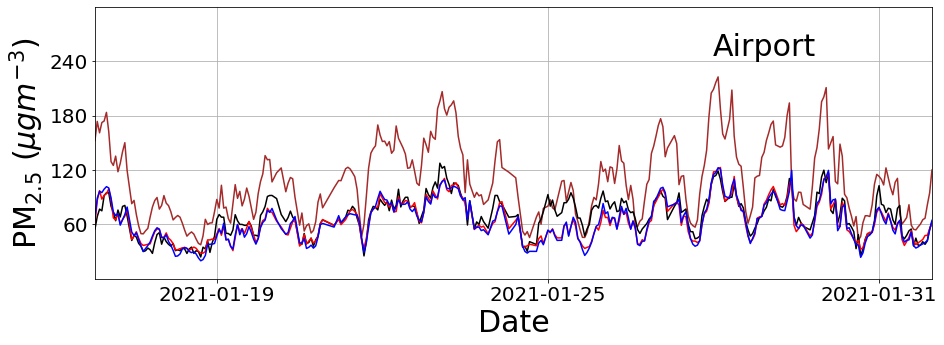

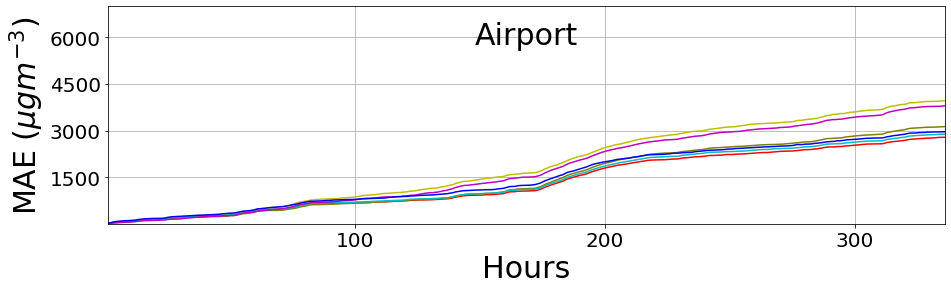

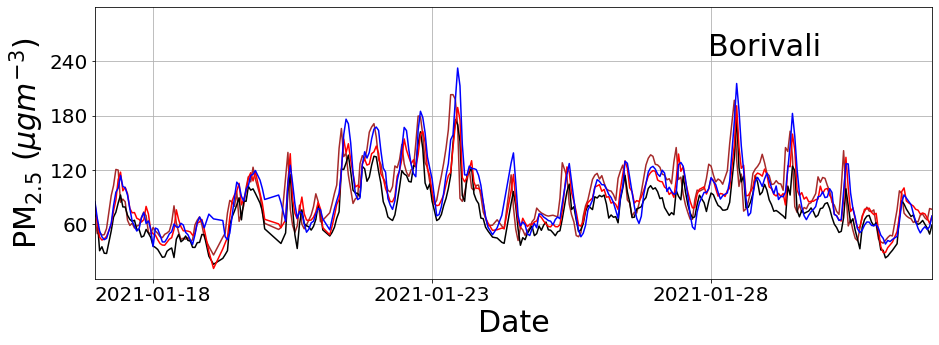

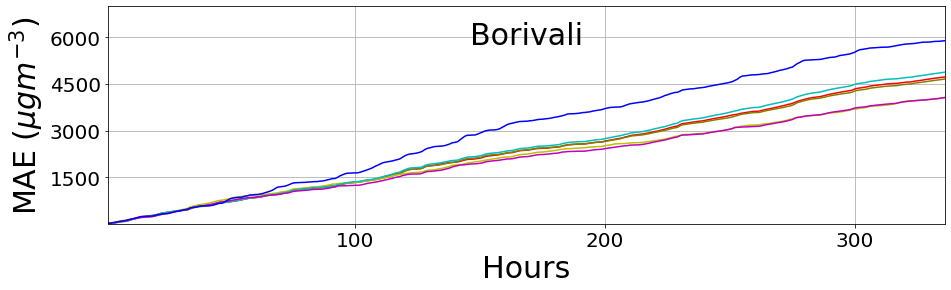

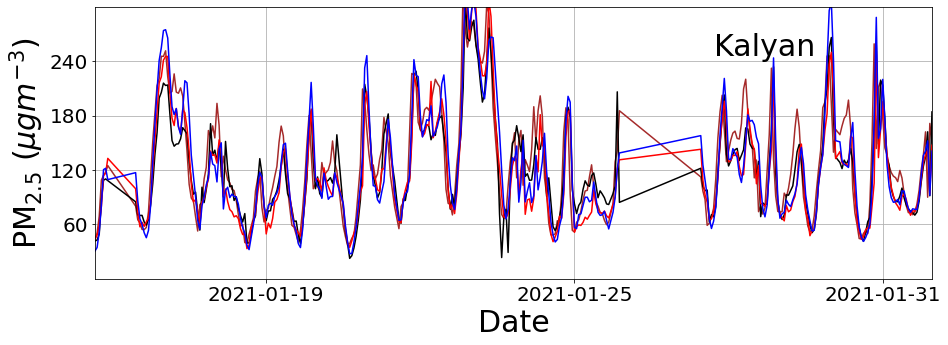

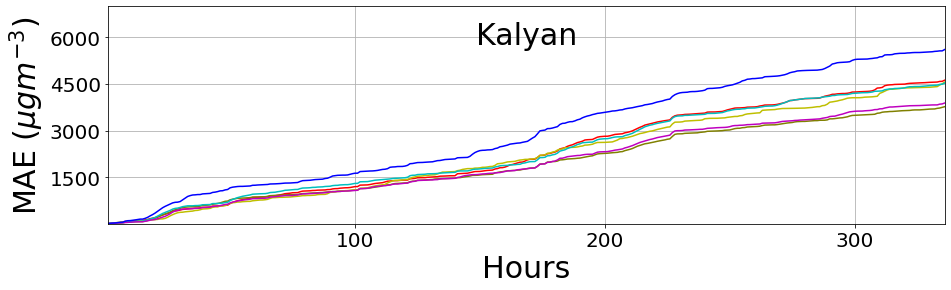

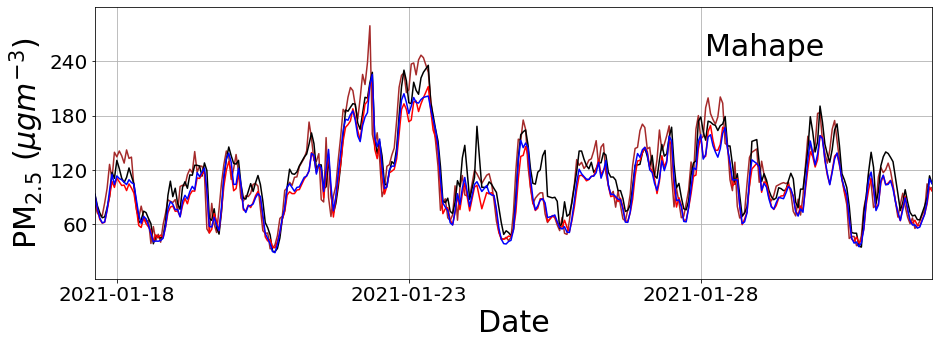

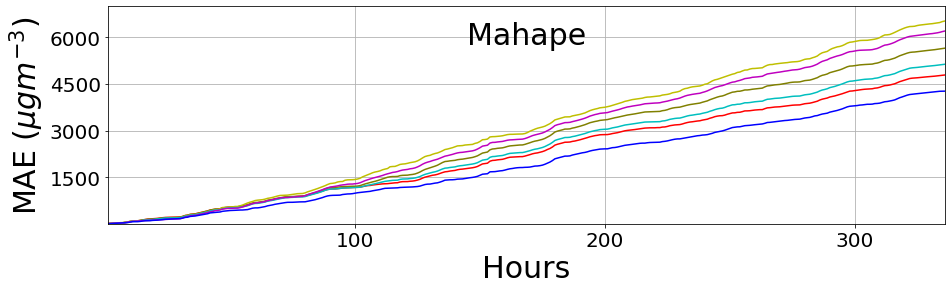

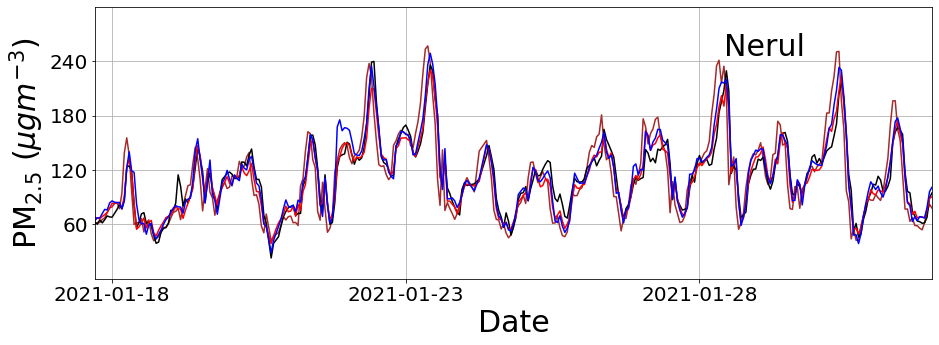

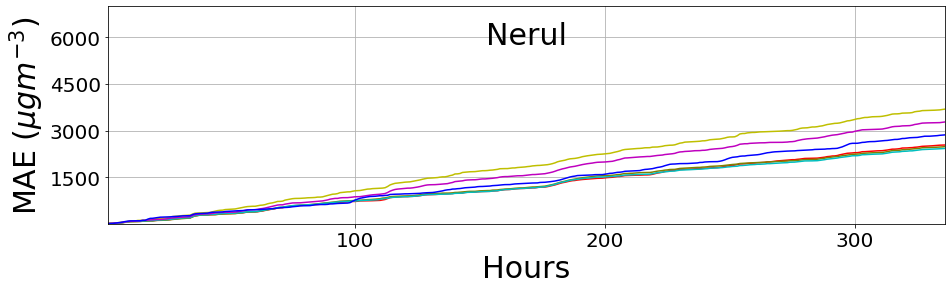

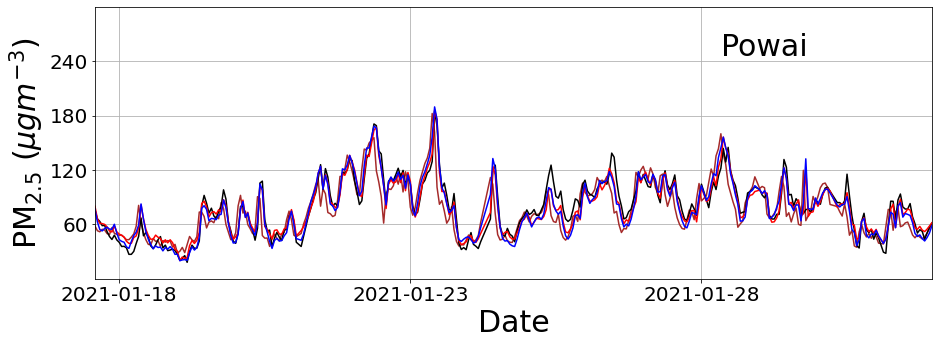

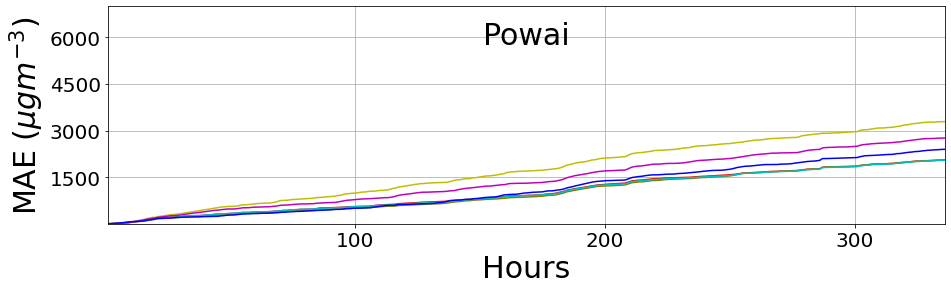

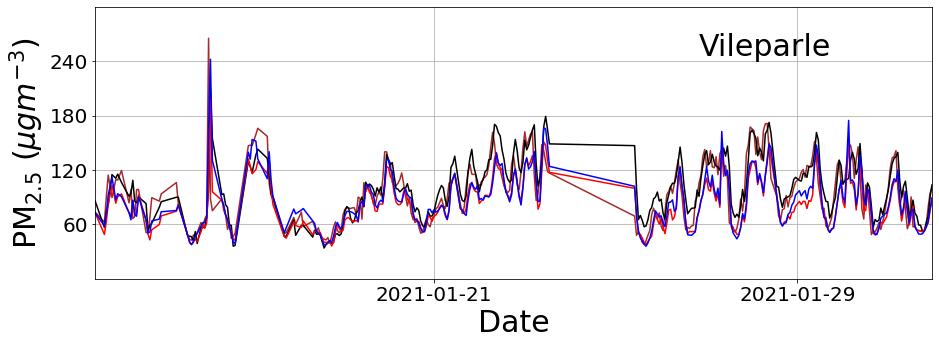

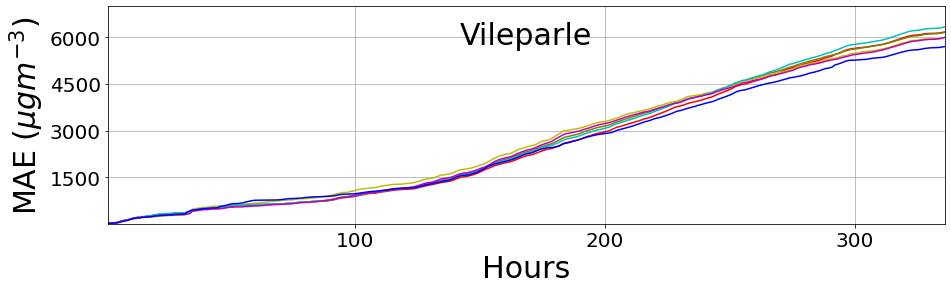

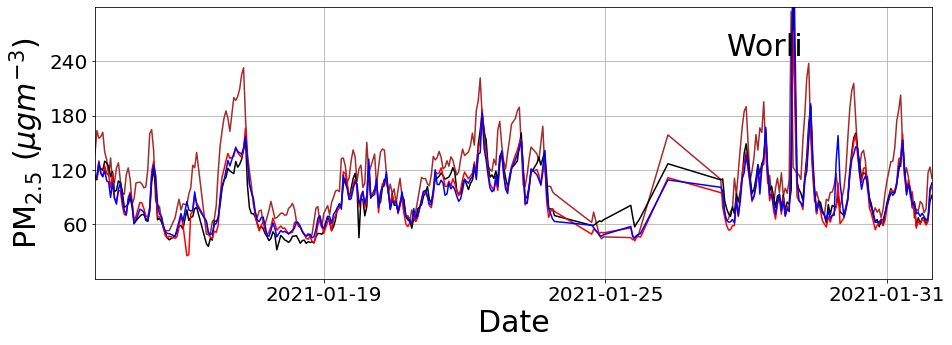

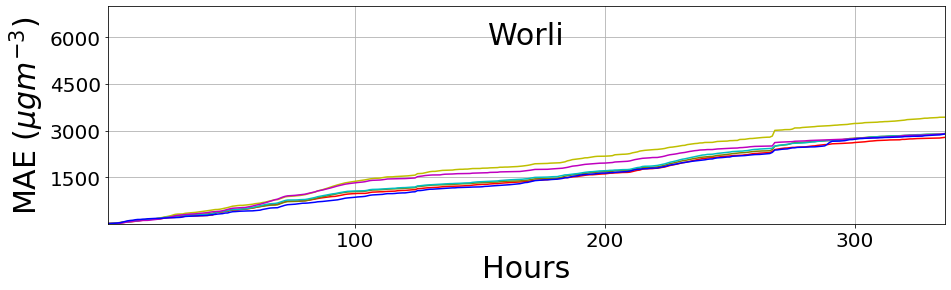

In [3]:
name_list = ['Airport','Borivali','Kalyan','Mahape','Nerul','Powai','Vileparle','Worli']
base_model(name_list)